In [84]:
import os, math
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
from subprocess import call

In [2]:
%matplotlib inline
l = matplotlib.rcParams['figure.figsize']
matplotlib.rcParams['figure.figsize'] = [l[0] * 4, l[1] * 4]

In [74]:
CQ_SOURCE_PATH = "../../cq-sources"
scala_versions = ['2.11', '2.12']

In [89]:
class Dependency(object):
    def __init__(self, org, name, version, tags=[]):
        self.org = org.strip()
        self.name = name.strip()
        self.version = version.strip()
        self.tags = tags

    def __hash__(self):
        return hash((self.org, self.name, self.version))

    def __repr__(self):
        return "%s:%s:%s" % (self.org, self.name, self.version)

    def __eq__(self, other):
        if isinstance(other, Dependency):
            return (self.org == other.org) and \
                   (self.name == other.name) and \
                   (self.version == other.version)
        else:
            return false

    def __neq__(self, other):
        return not self.__eq__(other)

    def source_link(self):
        (org, name, version) = (self.org, self.name, self.version)
        if not org.startswith("org.geotools"):
            s = (org.replace('.', '/'), name, version, name, version)
            return "http://search.maven.org/remotecontent?filepath=%s/%s/%s/%s-%s-sources.jar" % s
        else:
            s = (org.replace('.', '/'), name, version, name, version)
            return "http://download.osgeo.org/webdav/geotools/%s/%s/%s/%s-%s-sources.jar" % s

    def download_source(self, path=None):
        n = self.name
        for v in scala_versions:
            n = n.replace('_%s' % v, '')

        if not path:
            d = os.path.join(CQ_SOURCE_PATH, n)
            path = os.path.join(d, "%s-%s-%s-sources.zip" % (self.org, self.name, self.version))
        else:
            d = os.path.dirname(path)
            
        if not os.path.exists(d):
            os.makedirs(d)
        cmd = "wget -O %s %s" % (path, self.source_link())
        if call(cmd, shell=True) > 0:
            print(cmd)
            raise Exception("Download failed")

    @classmethod
    def from_string(cls, s):
        l = s.split(':')
        return cls(l[0], l[1], l[2])


In [ ]:
ls ../graphml


In [ ]:
g =   nx.read_graphml("../graphml/proj4.graphml")

In [ ]:
nx.draw(g)

In [ ]:
g.nodes()

In [ ]:
g.edge['com.opencsv:opencsv:3.9']

In [ ]:
g.out_edges()

In [ ]:
'commons-beanutils:commons-beanutils:1.9.3' in g.node

In [ ]:
g.add_edge(1, 2)

In [ ]:
g.edges(1)

In [ ]:
g.add_edge(1,3)

In [37]:
G = nx.read_gml("/Users/rob/proj/gt/geotrellis/scripts/dependencies.graphml")

In [ ]:
pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)

In [ ]:
d = DependencySet(G.node.keys())
d.version("org.locationtech.geotrellis", "geotrellis-raster_2.11")

In [ ]:
s = "ar.com.hjg:pngj:2.0.1"
G.node["org.locationtech.geotrellis:geotrellis-raster_2.11:1.1.0-SNAPSHOT"]
list(G.in_edges("org.locationtech.geotrellis:geotrellis-raster_2.11:1.1.0-SNAPSHOT"))

In [71]:
def find_heritage(dep):
    n = str(dep)
    #if dep.org == "org.locationtech.geotrellis":
    #    print(dep)
    #    return [[dep]]
    
    heritage_lines = []
    for (parent, _) in G.in_edges(n):
        for line in find_heritage(Dependency.from_string(parent)):
            line.append(dep)
            heritage_lines.append(line)
    if not heritage_lines:
        return [[dep]]
    else:
        return heritage_lines
        
def heritage_set(dep):
    s = set([])
    for d in find_heritage(dep):
        s.add(d)
    return s

def find_transitive_graph(dep):
    if not isinstance(dep, str):
        dep = str(dep)
    H = nx.DiGraph()
    for (_, target) in G.out_edges(dep):
        seen = target in H.node
        H.add_edge(dep, target)
        if not seen:
            H = nx.compose(H, find_transitive_graph(target))
    return H

def find_heritage_graph(dep):
    if not isinstance(dep, str):
        dep = str(dep)
    H = nx.DiGraph()
    for (source, _) in G.in_edges(dep):
        seen = source in H.node
        H.add_edge(source, dep)
        if not seen:
            H = nx.compose(H, find_heritage_graph(source))
    return H

def clip_subproject(dep):
    """
    Returns just the graph of a subproject and it's dependencies, clipping off
    the dependencies of other geotrellis projects
    """
    H = nx.DiGraph()
    def add_edges(d):
        for src, target in G.out_edges(d):
            print("%s -> %s" % (src, target))
            if Dependency.from_string(target).org != "org.locationtech.geotrellis":
                seen = target in H.node
                H.add_edge(src, target)
                if not seen:
                    add_edges(target)
    add_edges(dep)
    return H

def find_dep(s):
    l = []
    for n in G.node:
        d = Dependency.from_string(n)
        if s in d.org or s in d.name:
          l.append(d)
    return l

In [47]:
def draw_tree(s):
    ds = heritage_set(Dependency.from_string(s))
    H = G.subgraph(ds)
    pos = nx.spring_layout(H)
    nx.draw_networkx_nodes(H, pos)
    nx.draw_networkx_edges(H, pos)
    nx.draw_networkx_labels(H, pos)
    
def draw_graph(H):
    S = H.copy()
    S = nx.relabel_nodes(S, lambda x: Dependency.from_string(x).name)
    limits=plt.axis('off')
    pos = nx.spring_layout(S, iterations=20, k=(1/math.sqrt(len(H.node))*10))
    #pos = nx.nx_agraph.graphviz_layout(H)
    nx.draw_networkx_nodes(S, pos)
    nx.draw_networkx_edges(S, pos)
    nx.draw_networkx_labels(S, pos)

In [49]:
#d = "com.beust:jcommander:1.48"
#d = 'org.apache.accumulo:accumulo-minicluster:1.7.2'
#d = str(find_dep("machinist_2.11")[0])
d = str(find_dep("jsr305")[1])
for line in find_heritage(Dependency.from_string(d)):
    print(' -> '.join(map(lambda x: str(x), line)))
    print('\n')
    #print(line)
#draw_tree("com.beust:jcommander:1.48")

org.locationtech.geotrellis:geotrellis-spark-etl_2.11:1.1.0-SNAPSHOT -> com.github.fge:json-schema-validator:2.2.6 -> com.github.fge:json-schema-core:1.2.5 -> com.github.fge:uri-template:0.9 -> com.github.fge:msg-simple:1.1 -> com.google.code.findbugs:jsr305:2.0.1 -> com.google.code.findbugs:jsr305:3.0.0 -> com.google.code.findbugs:jsr305:3.0.1


org.locationtech.geotrellis:geotrellis-spark-etl_2.11:1.1.0-SNAPSHOT -> com.github.fge:json-schema-validator:2.2.6 -> com.github.fge:json-schema-core:1.2.5 -> com.github.fge:jackson-coreutils:1.8 -> com.github.fge:msg-simple:1.1 -> com.google.code.findbugs:jsr305:2.0.1 -> com.google.code.findbugs:jsr305:3.0.0 -> com.google.code.findbugs:jsr305:3.0.1


org.locationtech.geotrellis:geotrellis-spark-etl_2.11:1.1.0-SNAPSHOT -> com.github.fge:json-schema-validator:2.2.6 -> com.github.fge:json-schema-core:1.2.5 -> com.github.fge:uri-template:0.9 -> com.google.code.findbugs:jsr305:2.0.1 -> com.google.code.findbugs:jsr305:3.0.0 -> com.google.code.findb

In [44]:
# Wayne's list
l =["ar.com.hjg:pngj:2.0.1",
    "com.amazonaws:jmespath-java:1.11.92",
    "com.aol.simplereact:cyclops-react:1.0.0-RC4",
    "com.beust:jcommander:1.48",
    "com.esotericsoftware:kryo-shaded:3.0.3",
    "com.fasterxml.jackson.dataformat:jackson-dataformat-cbor:2.6.6",
    "com.github.fge:btf:1.2",
    "com.github.fge:json-schema-core:1.2.5",
    "com.github.fge:json-schema-validator:2.2.6",
    "com.github.fge:msg-simple:1.1",
    "com.github.fge:uri-template:0.9",
    "com.googlecode.efficient-java-matrix-library:core:0.26",
    "com.google.code.findbugs:annotations:3.0.1",
    "com.google.code.findbugs:jsr305:3.0.0",
    "com.google.code.findbugs:jsr305:3.0.1",
    "com.googlecode.libphonenumber:libphonenumber:6.2"]
ds = {}
for d in l:
    ds[d] = { 0: set([]), 1: set([]) }
    for line in find_heritage(Dependency.from_string(d)):
        ds[d][0].add(line[0])
        ds[d][1].add(line[1])
for d in ds:
    print(d)
    for x in ds[d][0]:
        print("\t%s" % x)
    for x in ds[d][1]:
        print("\t\t%s" % x)    

com.google.code.findbugs:jsr305:3.0.1
	org.locationtech.geotrellis:geotrellis-spark-etl_2.11:1.1.0-SNAPSHOT
	org.locationtech.geotrellis:geotrellis-geowave_2.11:1.1.0-SNAPSHOT
		mil.nga.giat:geowave-datastore-accumulo:0.9.3
		org.geoserver:gs-wms:2.10.1
		mil.nga.giat:geowave-core-geotime:0.9.3
		com.github.fge:json-schema-validator:2.2.6
		mil.nga.giat:geowave-adapter-raster:0.9.3
		mil.nga.giat:geowave-core-store:0.9.3
		mil.nga.giat:geowave-adapter-vector:0.9.3
com.beust:jcommander:1.48
	org.locationtech.geotrellis:geotrellis-geomesa_2.11:1.1.0-SNAPSHOT
	org.locationtech.geotrellis:geotrellis-spark-etl_2.11:1.1.0-SNAPSHOT
	org.locationtech.geotrellis:geotrellis-geowave_2.11:1.1.0-SNAPSHOT
		mil.nga.giat:geowave-datastore-accumulo:0.9.3
		org.apache.accumulo:accumulo-core:1.7.2
		mil.nga.giat:geowave-core-geotime:0.9.3
		mil.nga.giat:geowave-adapter-raster:0.9.3
		org.locationtech.geomesa:geomesa-jobs:1.2.7.3
		mil.nga.giat:geowave-core-store:0.9.3
		org.locationtech.geotrellis:geotr

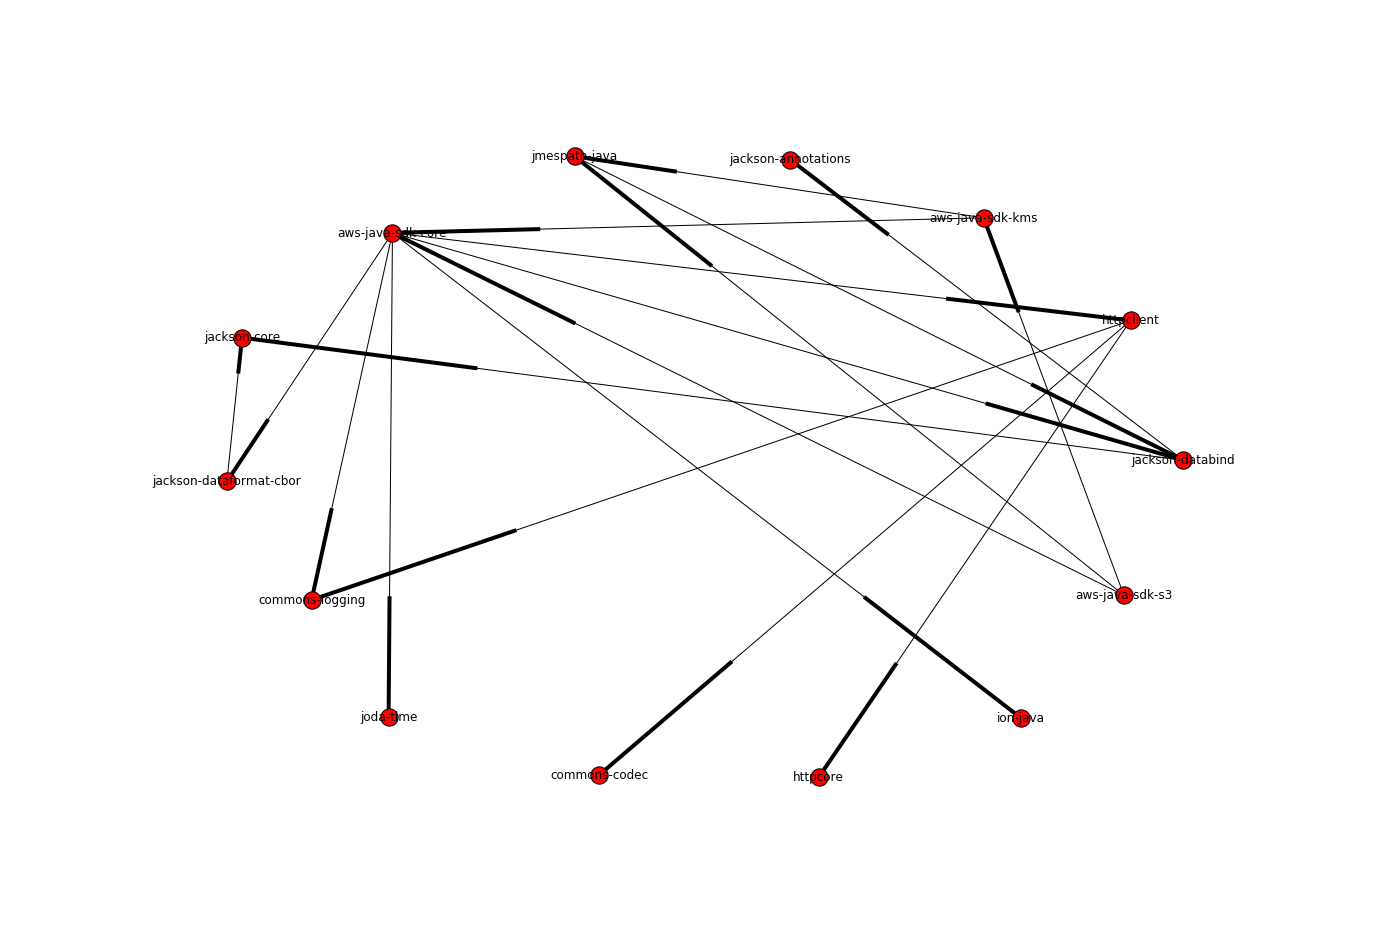

In [73]:
#G.node["com.googlecode.efficient-java-matrix-library:core:0.26"]
T = find_transitive_graph("com.amazonaws:aws-java-sdk-s3:1.11.92")
#T = find_heritage_graph("com.googlecode.efficient-java-matrix-library:core:0.26")
draw_graph(T)
#T.node

In [13]:
G.in_edges('mil.nga.giat:geowave-datastore-accumulo:0.9.3')

[]

org.locationtech.geotrellis:geotrellis-shapefile_2.11:1.1.0-SNAPSHOT -> org.geotools:gt-shapefile:16.1
org.geotools:gt-shapefile:16.1 -> org.jdom:jdom:1.1.3
org.geotools:gt-shapefile:16.1 -> org.geotools:gt-data:16.1
org.geotools:gt-data:16.1 -> org.geotools:gt-main:16.1
org.geotools:gt-main:16.1 -> com.vividsolutions:jts:1.13
org.geotools:gt-main:16.1 -> org.jdom:jdom:1.1.3
org.geotools:gt-main:16.1 -> javax.media:jai_core:1.1.3
org.geotools:gt-main:16.1 -> org.geotools:gt-api:16.1
org.geotools:gt-api:16.1 -> com.vividsolutions:jts:1.13
org.geotools:gt-api:16.1 -> org.geotools:gt-referencing:16.1
org.geotools:gt-referencing:16.1 -> com.googlecode.efficient-java-matrix-library:core:0.26
org.geotools:gt-referencing:16.1 -> javax.media:jai_core:1.1.3
org.geotools:gt-referencing:16.1 -> org.geotools:gt-metadata:16.1
org.geotools:gt-metadata:16.1 -> org.geotools:gt-opengis:16.1
org.geotools:gt-opengis:16.1 -> net.java.dev.jsr-275:jsr-275:1.0-beta-2
org.geotools:gt-opengis:16.1 -> commons-p

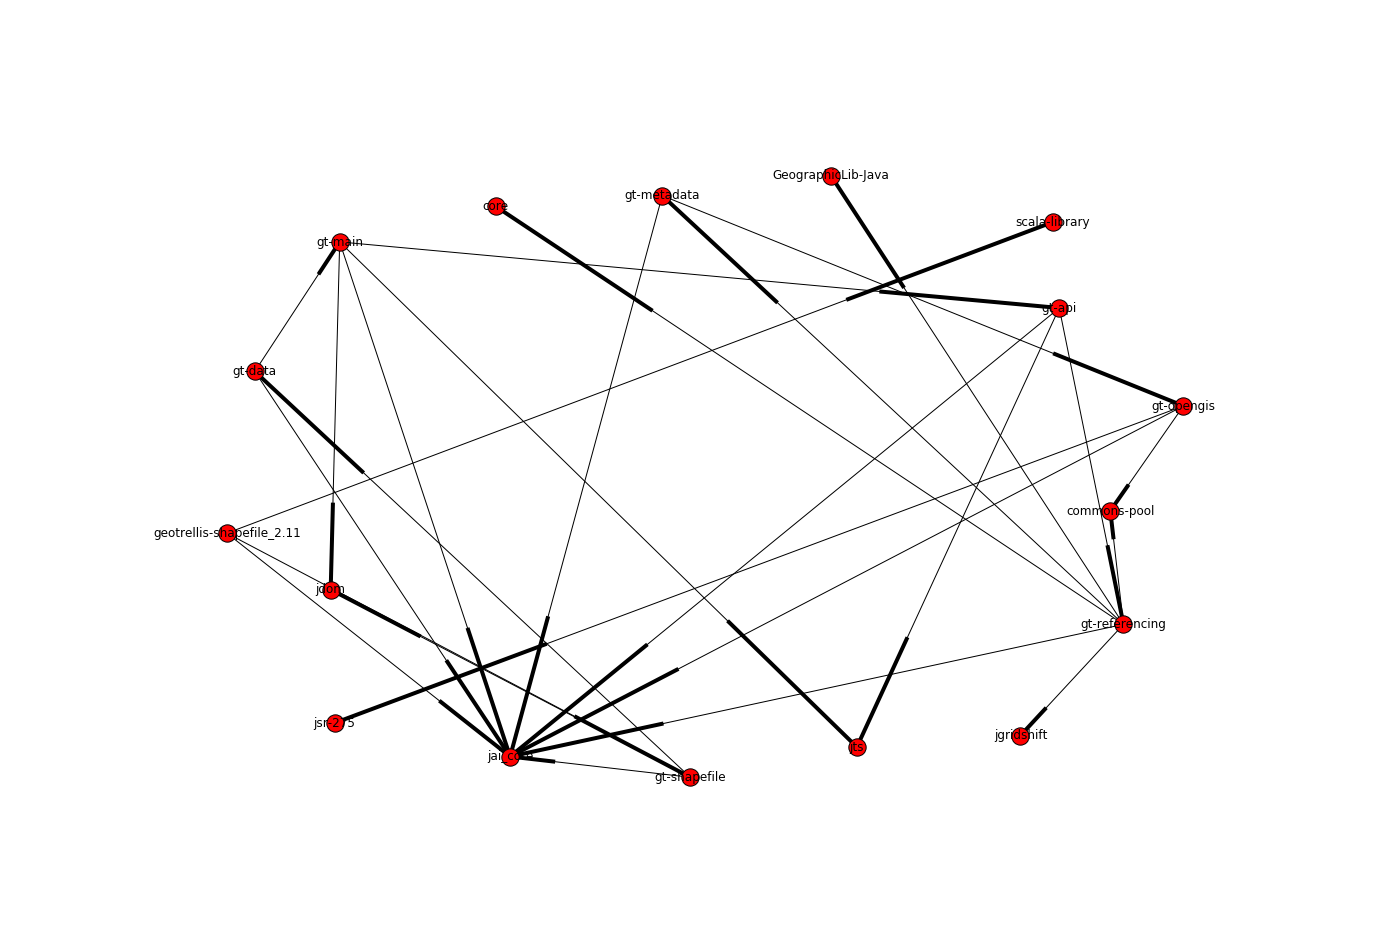

In [68]:
#d = str(find_dep("machinist_2.11")[0])
d = str(find_dep("geotrellis-raster_2.11")[0])
draw_graph(clip_subproject("org.locationtech.geotrellis:geotrellis-shapefile_2.11:1.1.0-SNAPSHOT"))
#draw_graph(G)
#G.out_edges(d)

In [91]:
d = Dependency.from_string("com.fasterxml.jackson.dataformat:jackson-dataformat-cbor:2.6.6")
d.download_source()

In [88]:
!wget -O ../../cq-sources/jmespath-java http://search.maven.org/remotecontent?filepath=com/amazonaws/jmespath-java/1.11.92/jmespath-java-1.11.92-sources.jar
    

../../cq-sources/jmespath-java: Is a directory
